<a href="https://colab.research.google.com/github/AnnaGass/DSA-SleepHealthData/blob/main/multivariante_Regression_und_Korrelationsmatrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
# @title # Select the subject to be used { display-mode: "both" }
subject = '027'

# Install python libraries and load packages

In [49]:
# @title Install needed libraries { display-mode: "both" }
!pip install pyedflib
!pip install pandas

In [50]:
# @title Import libraries { display-mode: "both" }
import subprocess
import pyedflib
import csv
import os

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from datetime import timedelta
from datetime import datetime

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Import data

In [51]:
# @title Define constants { display-mode: "both" }
base_url = "https://physionet.org/files/ucddb/1.0.0/ucddb" + subject
orig_data = "/content/physionet.org/files/ucddb/1.0.0/ucddb" + subject
output_directory = "data_preparation/subject" + subject + "/"

In [52]:
# @title Import the data from physionet { display-mode: "both" }

base_command = "wget -r -N -c -np "

rec_path = base_url + ".rec"
sleep_annotation_path = base_url + "_stage.txt"
apnea_annotation_path = base_url + "_respevt.txt"

command = base_command + rec_path
result = subprocess.run(command, shell=True, capture_output=True, text=True)

command = base_command + sleep_annotation_path
result = subprocess.run(command, shell=True, capture_output=True, text=True)

command = base_command + apnea_annotation_path
result = subprocess.run(command, shell=True, capture_output=True, text=True)

# Prepare the data

In [53]:
# @title Create output directory for subject

# Create results folder if not exists
if not os.path.exists("results"):
    os.makedirs("results")

if not os.path.exists(output_directory):
  os.makedirs(output_directory)

In [54]:
# @title Extract signals from .rec file { display-mode: "both" }

# open the input file
rec_file_path = orig_data + ".rec"
f = pyedflib.EdfReader(rec_file_path)

# Specify the output file name
signals_csv = output_directory + "01_orig_signals.csv"

# Specify which signals to use
spo2_index = 6      # taken from the headers
pulse_index = 13    # taken from the headers

# Initialize an empty list to store your values
data = []

# file properties
start_time = f.getStartdatetime()
file_duration = f.getFileDuration()
signal_labels = f.getSignalLabels()

# SpO2 information
spo2_header = f.getSignalHeader(spo2_index)
spo2_signals = f.readSignal(spo2_index)

# Pulse information
pulse_header = f.getSignalHeader(pulse_index)
pulse_signals = f.readSignal(pulse_index)

# Calculate frequency
time_between_meassurements = file_duration / len(pulse_signals)

# Iterate and add the increment to the datetime on each iteration
for i in range(len(pulse_signals)):
    date_str = start_time.strftime('%Y-%m-%d')
    if start_time.microsecond != 0:
       time_str = start_time.strftime('%H:%M:%S.%f')
    else:
       time_str = start_time.strftime('%H:%M:%S')
    data.append([date_str, time_str, spo2_signals[i], pulse_signals[i]])
    start_time += timedelta(seconds=time_between_meassurements)

# Write the data to a CSV file
with open(signals_csv, 'w', newline='') as file:
    # Create a CSV writer object for the output file
    writer = csv.writer(file)
    # Write the header
    writer.writerow(['Date', 'Time', 'SpO2', 'Pulse'])
    writer.writerows(data)
f.close()

In [55]:
# @title Extract data from respevt.txt file { display-mode: "both" }

# Specify the input file name
annotations_path = orig_data + "_respevt.txt"

# Specify the output file name
output_csv_annotations = output_directory + "02_apnea_annotations.csv"

# Open the input file
with open(annotations_path, 'r') as infile:
    # Skip the first two lines (header)
    next(infile)
    next(infile)
    next(infile)

    # Open a CSV file for writing with more parameters
    with open(output_csv_annotations, 'w', newline='') as outfile_extra:
        # Create a CSV writer object for the output file
        writer = csv.writer(outfile_extra)

        # Write the header
        writer.writerow(['Time', 'Apnea'])

        # Process each line in the input file
        for line in infile:
            # Split the line into columns
            columns = line.split()

            # Check if the line has enough columns
            if len(columns) >= 5:

                # Extract the required columns
                time_str = columns[0]
                event_type = columns[1]
                duration_str = columns[2] if columns[2] != "EVENT" else columns[4]


                # Parse duration into seconds
                duration_seconds = int(duration_str)

                # Parse time string into datetime object
                time = datetime.strptime(time_str, '%H:%M:%S')

                # Iterate over the duration and add one second to the time in each iteration
                for _ in range(duration_seconds):

                    # Write the time, event type, and duration to the CSV file
                    writer.writerow([time.strftime('%H:%M:%S'), event_type])

                    # Add one second to the time
                    time += timedelta(seconds=1)

In [56]:
# @title Extract data from "stage.txt" file

# Specify the input file name
input_stage = orig_data + "_stage.txt"

# Specify the output file name
output_csv_stage = output_directory + "03_sleep_stages.csv"

# Open the input text file in read mode and the output CSV file in write mode
with open(input_stage, 'r') as infile:
  with open(output_csv_stage, 'w', newline='') as outfile_stage:
        # Create a CSV writer object for the output file
        writer = csv.writer(outfile_stage)

        # Write the header
        writer.writerow(['Sleep Stage'])

        # Process each line in the input file
        for line in infile:
            # Remove leading and trailing whitespace and split the line into columns
            line = line.strip()
            # Write the sleep stage value to the CSV file
            writer.writerow([line])

In [57]:
# @title sort the data in the signals.csv and merge it with stage.csv and anno.csv { display-mode: "both" }

merged_csv = output_directory + "04_merged.csv"

# Load data from the _signals.csv file
df_signals = pd.read_csv(signals_csv)

# Sort the data to keep only the rows where the time values have seconds only
df_signals = df_signals[df_signals['Time'].str.contains(r'^\d{2}:\d{2}:\d{2}$')]
df_signals_withoutmiliseconds = df_signals.copy()

# Load data from the _apnea_anno_extra.csv file and merge it with the filtered signal data using the 'Time' column
df_apnea_anno_extra = pd.read_csv(output_csv_annotations)
df_merged_anno = pd.merge(df_signals_withoutmiliseconds, df_apnea_anno_extra, on='Time', how='left')

# =================================================================================================

# Load data from the _stage.csv file
df_apnea_stage = pd.read_csv(input_stage, dtype=int)

# Initialize an empty list to store combined data
combined_data = []

for i in range(len(df_signals_withoutmiliseconds)):
    # Calculate the index for the data from df_apnea_stage based on the 30-second intervals
    apnea_index = i // 30

    # Ensure the index does not exceed the number of rows in df_apnea_stage
    apnea_index = min(apnea_index, len(df_apnea_stage) - 1)

    # Append the corresponding entry from df_apnea_stage to the combined data list
    combined_data.append(df_apnea_stage.iloc[apnea_index].tolist())

# Convert the combined data list into a DataFrame
df_combined_stage = pd.DataFrame(combined_data, columns=df_apnea_stage.columns)

# Merge the combined data with the merged signal and annotation data
df_merged_stage = pd.concat([df_merged_anno, df_combined_stage], axis=1)

# Save the merged data to a new CSV file
df_merged_stage.to_csv(merged_csv, index=False)

# Data Analysis

In [58]:
# @title Remove all datasets where SpO2 < 80 or 40 < Pulse < 180 (Meassurement error)

# Load the CSV file into a DataFrame
df = pd.read_csv(merged_csv)

merged_clean_csv = output_directory + "05_merged_clean.csv"

spo2_threshold = 70
pulse_lower_threshold = 40
pulse_upper_threshold = 180

df = df[df['SpO2'] >= spo2_threshold]
df = df[df['Pulse'] >= pulse_lower_threshold]
df = df[df['Pulse'] <= pulse_upper_threshold]

# Save the filtered DataFrame to a new CSV file
df.to_csv(merged_clean_csv, index=False)

In [59]:
# @title Categorize SpO2 { display-mode: "both" }
# @markdown 0-70 = Invalid, 70-80 = Severe Hypoxia, 80-90 = Critical, 90-94 = Decreased, 94-100 = Normal

# Load the CSV file into a DataFrame
df = pd.read_csv(merged_clean_csv)

# Define the name of the output file
spo2_categorized_csv = output_directory + "06_spo2_categorized.csv"

# Define the categorization function
def categorize_spo2(value):
    if value >= 0 and value < 70:
        return 'Invalid'
    elif value >= 70 and value < 80:
        return 'Severe Hypoxia'
    elif value >= 80 and value < 90:
        return 'Critical'
    elif value >= 90 and value < 94:
        return 'Decreased'
    elif value >= 94 and value <= 100:
        return 'Normal'
    else:
        return 'Out of Range'  # In case the value is out of the expected range

# Apply the categorization function to the relevant column
df['SpO2 Category'] = df['SpO2'].apply(categorize_spo2)

# Save the DataFrame to a new CSV file (optional)
df.to_csv(spo2_categorized_csv, index=False)

In [60]:
# @title Categorize Pulse { vertical-output: true }
# @markdown Bin size = (max_value - min_value) / number_of_bins
number_of_bins = 7 # @param {type:"integer"}


# Load the CSV file into a DataFrame
df = pd.read_csv(spo2_categorized_csv)

# Define the name of the output file
pulse_categorized_csv = output_directory + "07_pulse_categorized.csv"

# Find out the smallest and biggest values for pulse
min_value = df['Pulse'].min()
max_value = df['Pulse'].max()

# Calculate the bin size
bin_size = (max_value - min_value) / number_of_bins

# Create a list of bin edges
bin_edges = [min_value + i * bin_size for i in range(number_of_bins + 1)]

# Function to assign value to correct bin
def categorize_pulse(value):
    for i in range(number_of_bins):
        if bin_edges[i] <= value < bin_edges[i + 1]:
            return f'[{bin_edges[i]:.2f} - {bin_edges[i + 1]:.2f}]'
    return f'[{bin_edges[-2]:.2f} - {bin_edges[-1]:.2f}]'  # For the last bin

# Apply the categorization function to the relevant column
df['Pulse Range'] = df['Pulse'].apply(categorize_pulse)

# Save the filtered and categorized DataFrame to a new CSV file
df.to_csv(pulse_categorized_csv, index=False)


In [61]:
# @title Set the correct text for sleep phase

# Load the CSV file into a DataFrame
df = pd.read_csv(pulse_categorized_csv)

# Define the name of the output file
sleep_stage_text_csv = output_directory + "08_sleep_stage_text.csv"

# Define the mapping for the "Sleep Stage" column
sleep_stage_mapping = {
    0: 'Wake',
    1: 'REM',
    2: 'Stage 1',
    3: 'Stage 2',
    4: 'Stage 3',
    5: 'Stage 4',
    6: 'Artifact',
    7: 'Indeterminate'
}

# Apply the mapping to the "Sleep Stage" column
df['0'] = df['0'].map(sleep_stage_mapping)

# Save the updated DataFrame to a new CSV file
df.to_csv(sleep_stage_text_csv, index=False)

In [62]:
# @title Simplify apnoe class

# Load the CSV file into a DataFrame
df = pd.read_csv(sleep_stage_text_csv)

# Define the name of the output file
final_csv = output_directory + "09_final.csv"

def normalize_apnea_column(value):
    if str(value).startswith('AP'):
        return 'Apnea'
    elif str(value).startswith('HYP'):
        return 'Hypoapnea'
    else:
        return 'Nothing'

# Apply the normalization function to the target class
df['Apnea'] = df['Apnea'].apply(normalize_apnea_column)

# Save the filtered, categorized, and normalized DataFrame to a new CSV file
df.to_csv(final_csv, index=False)

# Data visualization

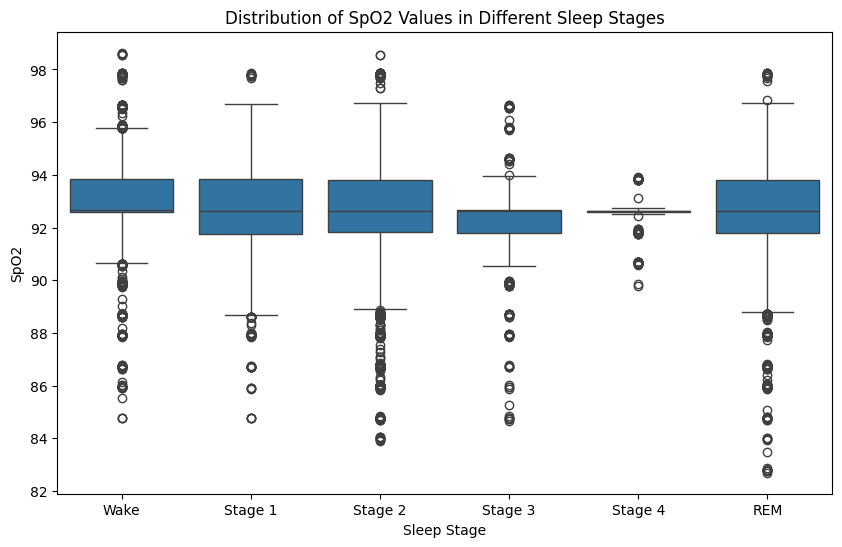

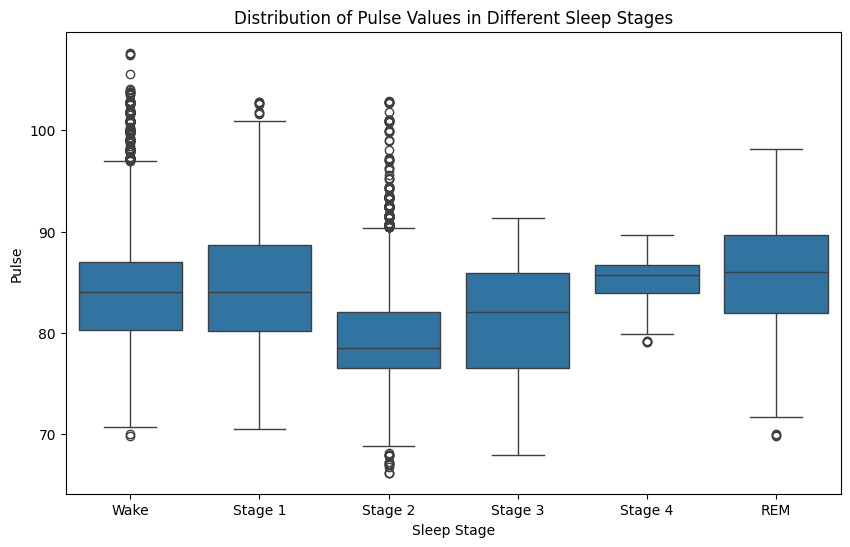

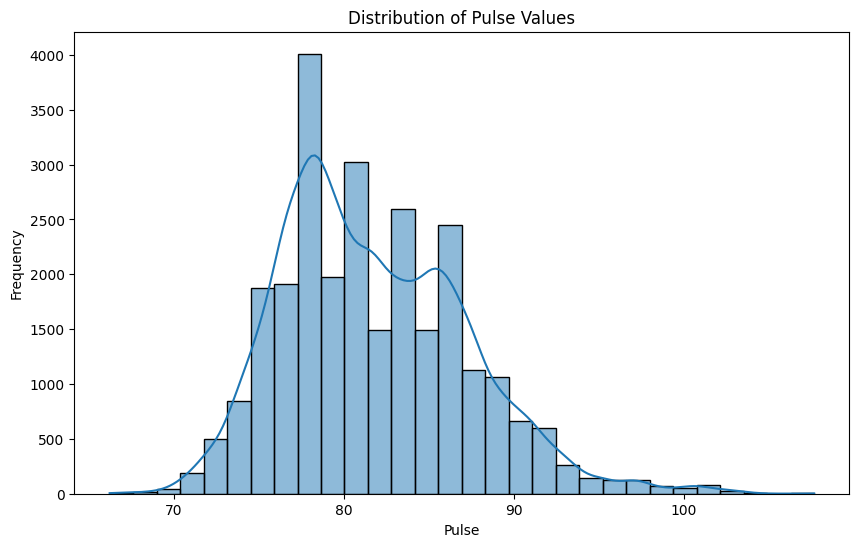

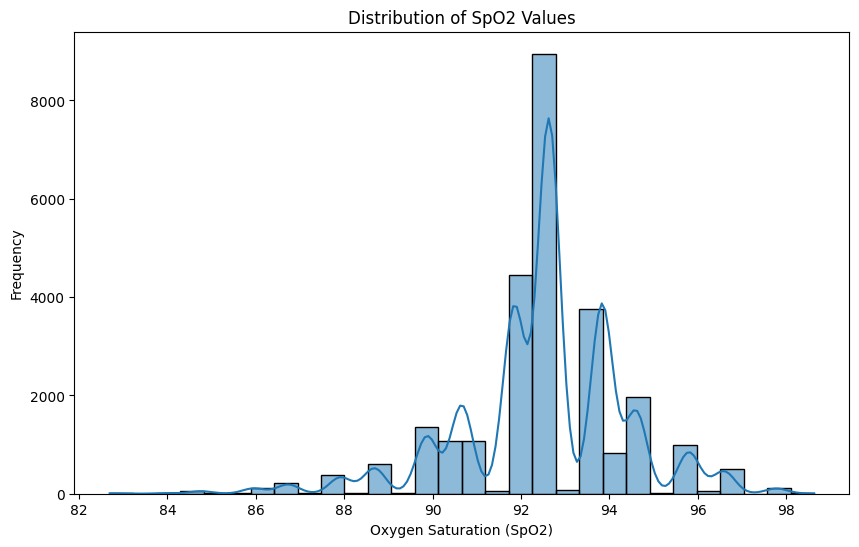

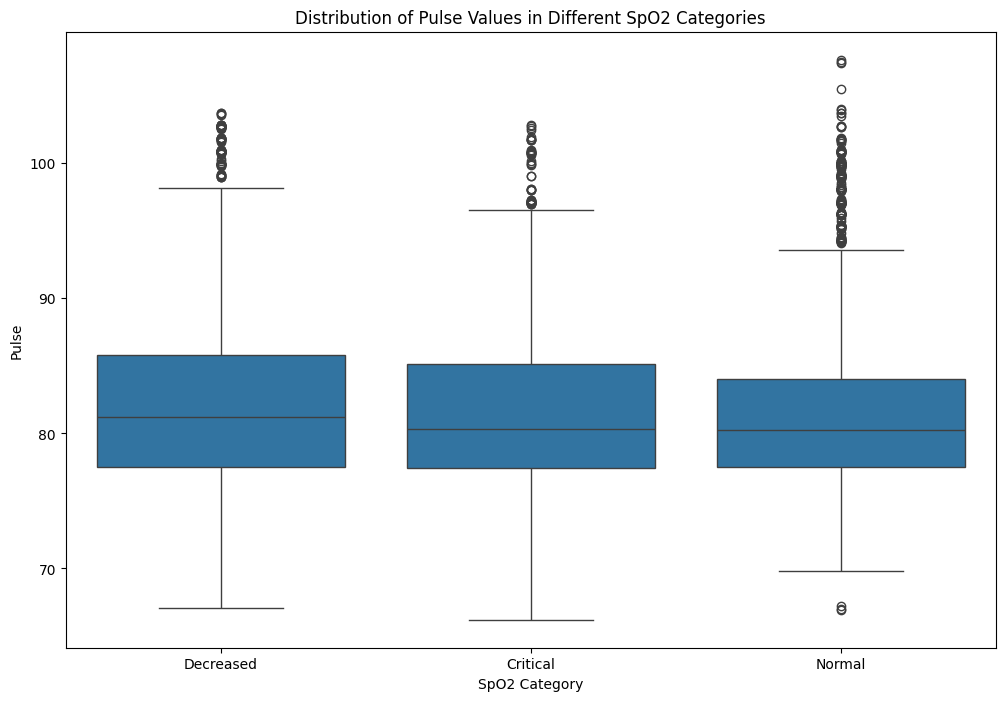

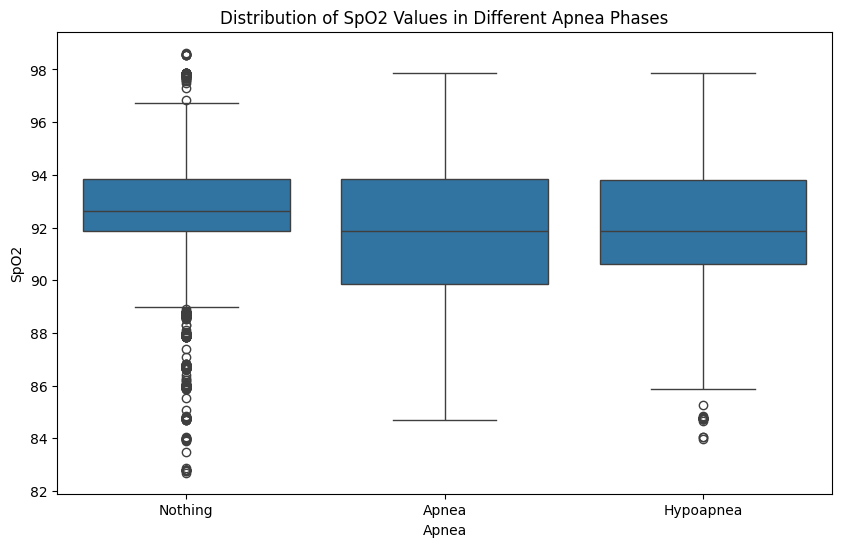

In [63]:
# @title data visualization, different plots { display-mode: "both" }

# Load the data
df = pd.read_csv(final_csv)

# Boxplot for SpO2 values in different sleep stages
plt.figure(figsize=(10, 6))
sns.boxplot(x='0', y='SpO2', data=df)
plt.xlabel('Sleep Stage')
plt.ylabel('SpO2')
plt.title('Distribution of SpO2 Values in Different Sleep Stages')
plt.show()

# Boxplot for Pulse values in different sleep stages
plt.figure(figsize=(10, 6))
sns.boxplot(x='0', y='Pulse', data=df)
plt.xlabel('Sleep Stage')
plt.ylabel('Pulse')
plt.title('Distribution of Pulse Values in Different Sleep Stages')
plt.show()

# Histogram of Pulse values
plt.figure(figsize=(10, 6))
sns.histplot(df['Pulse'], bins=30, kde=True)
plt.xlabel('Pulse')
plt.ylabel('Frequency')
plt.title('Distribution of Pulse Values')
plt.show()

# Histogram of SpO2 values
plt.figure(figsize=(10, 6))
sns.histplot(df['SpO2'], bins=30, kde=True)
plt.xlabel('Oxygen Saturation (SpO2)')
plt.ylabel('Frequency')
plt.title('Distribution of SpO2 Values')
plt.show()

# Boxplot for Pulse values in different SpO2 categories
plt.figure(figsize=(12, 8))
sns.boxplot(x='SpO2 Category', y='Pulse', data=df)
plt.xlabel('SpO2 Category')
plt.ylabel('Pulse')
plt.title('Distribution of Pulse Values in Different SpO2 Categories')
plt.show()

# Boxplot for SpO2 values in different Apnea phases
plt.figure(figsize=(10, 6))
sns.boxplot(x='Apnea', y='SpO2', data=df)
plt.xlabel('Apnea')
plt.ylabel('SpO2')
plt.title('Distribution of SpO2 Values in Different Apnea Phases')
plt.show()


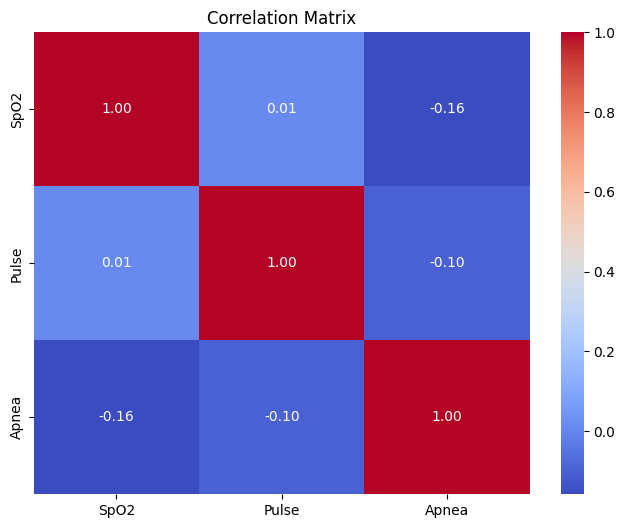

Correlations with Apnea:
SpO2    -0.157830
Pulse   -0.099581
Apnea    1.000000
Name: Apnea, dtype: float64


In [64]:
# @title create korrelationmatrix { display-mode: "both" }

# Load the data
df = pd.read_csv(final_csv)

# encoding for the categorical variable "Apnea"
df['Apnea'] = df['Apnea'].map({'Nothing': 0, 'Apnea': 1, 'Hypoapnea': 2})

# Select the columns
selected_columns = ['SpO2', 'Pulse', 'Apnea']

# Create a correlation matrix
correlation_matrix = df[selected_columns].corr()

# Plot the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# Summary of correlations
correlation_summary = correlation_matrix['Apnea']

print("Correlations with Apnea:")
print(correlation_summary)


**GER:**

Die Korrelation zwischen Apnea und SpO2 beträgt ungefähr -0,16. Dies deutet darauf hin, dass eine niedrigere Sauerstoffsättigung (SpO2) tendenziell mit einem höheren Apnoe-Index korreliert ist.
Mit anderen Worten, wenn die Sauerstoffsättigung abnimmt, steigt die Wahrscheinlichkeit für das Auftreten von Apnoe-Ereignissen.

Die Korrelation zwischen Apnea und Pulse beträgt ungefähr -0,10.
Ähnlich wie bei SpO2 deutet dies darauf hin, dass ein höherer Puls mit einem höheren Apnoe-Index korreliert ist.
Ein höherer Puls könnte auf eine gesteigerte Atmung oder Stress hinweisen, was wiederum mit einem erhöhten Risiko für Apnoe verbunden sein könnte.


**ENG:**

The correlation between apnea and SpO2 is approximately -0.16. This indicates that lower oxygen saturation (SpO2) tends to correlate with a higher apnea index.
In other words, as oxygen saturation decreases, the likelihood of apnea events increases.

The correlation between apnea and pulse is approximately -0.10.
Similar to SpO2, this indicates that a higher pulse is correlated with a higher apnea index.
A higher pulse rate could indicate increased breathing or stress, which in turn could be associated with an increased risk of apnea.


Number of Apnea Events: 2489
Number of Hypopnea Events: 3104
Number of Nothing Events: 21190
Total Sleep Time in Hours: 7.44
Total AHI Index: 751.78


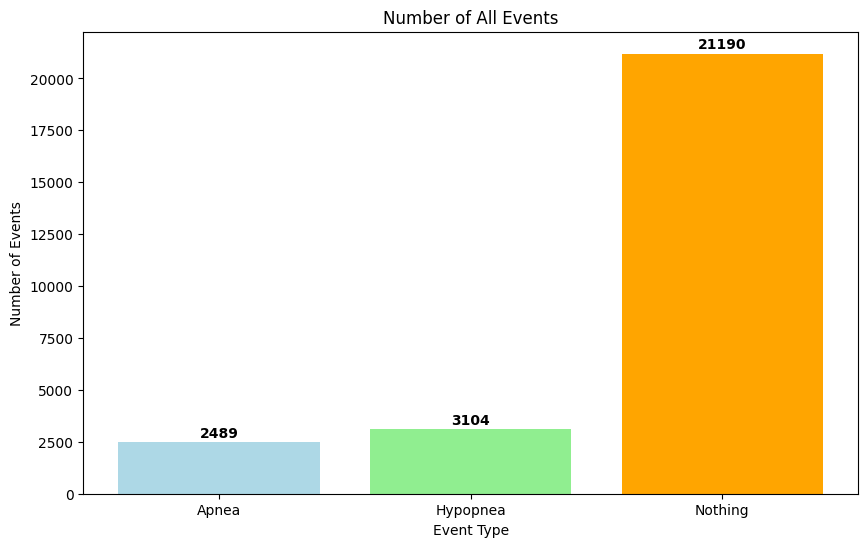

In [65]:
# @title calculate AHI Index { display-mode: "both" }

# Load the data
df = pd.read_csv(final_csv)

# Count the number of Apnea and Hypopnea events
total_apnea_events = df[df['Apnea'] == 'Apnea'].shape[0]
total_hypoapnea_events = df[df['Apnea'] == 'Hypoapnea'].shape[0]
total_nothing_events = df[df['Apnea'] == 'Nothing'].shape[0]

print("Number of Apnea Events:", total_apnea_events)
print("Number of Hypopnea Events:", total_hypoapnea_events)
print("Number of Nothing Events:", total_nothing_events)

total_events = total_apnea_events + total_hypoapnea_events

# Calculate the total sleep time in hours, each row = one second of sleep
total_sleep_seconds = len(df)
total_sleep_hours = total_sleep_seconds / 3600

# Calculate the total AHI
ahi_total = total_events / total_sleep_hours

print(f"Total Sleep Time in Hours: {total_sleep_hours:.2f}")
print(f"Total AHI Index: {ahi_total:.2f}")

plt.figure(figsize=(10, 6))
plt.bar(['Apnea', 'Hypopnea', 'Nothing'], [total_apnea_events, total_hypoapnea_events, total_nothing_events], color=['lightblue', 'lightgreen', 'orange'])
plt.xlabel('Event Type')
plt.ylabel('Number of Events')
plt.title('Number of All Events')

# Add annotations in the plot
for i, v in enumerate([total_apnea_events, total_hypoapnea_events, total_nothing_events]):
    plt.text(i, v + 100, str(v), ha='center', va='bottom', fontweight='bold')

plt.show()


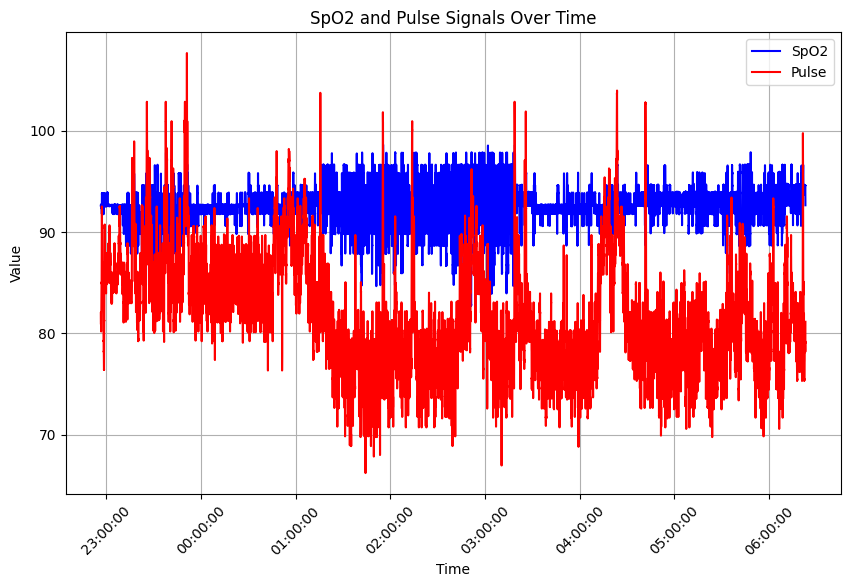

In [66]:
# @title Plot the signals from subject[XXX]_signals.csv { display-mode: "both" }

# Load data
df = pd.read_csv(final_csv)

# Define the ouput for the diagramm
plot_png = output_directory + "signals_plot.png"

# Assuming the columns are in order: date, time, spo2, and pulse
date = df['Date']
time = df['Time']
spo2 = df['SpO2']
pulse = df['Pulse']

# Combine date and time into a single string column 'Timestamp'
df['Timestamp'] = df['Date'] + ' ' + df['Time']

# Parse each datetime string into a datetime object
datetime_objects = []
for dt_str in df['Timestamp']:
    try:
        # Try parsing with milliseconds
        dt_obj = datetime.strptime(dt_str, "%Y-%m-%d %H:%M:%S.%f")
    except ValueError:
        # If milliseconds are not present, parse without milliseconds
        dt_obj = datetime.strptime(dt_str, "%Y-%m-%d %H:%M:%S")
    datetime_objects.append(dt_obj)


# Plotting
plt.figure(figsize=(10, 6))
plt.plot(datetime_objects, df['SpO2'], label='SpO2', color='blue')
plt.plot(datetime_objects, df['Pulse'], label='Pulse', color='red')

plt.title('SpO2 and Pulse Signals Over Time')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

# Set the format of the x-axis ticks to display only the time part
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Save the plot to a file
plt.savefig(plot_png)

plt.show()

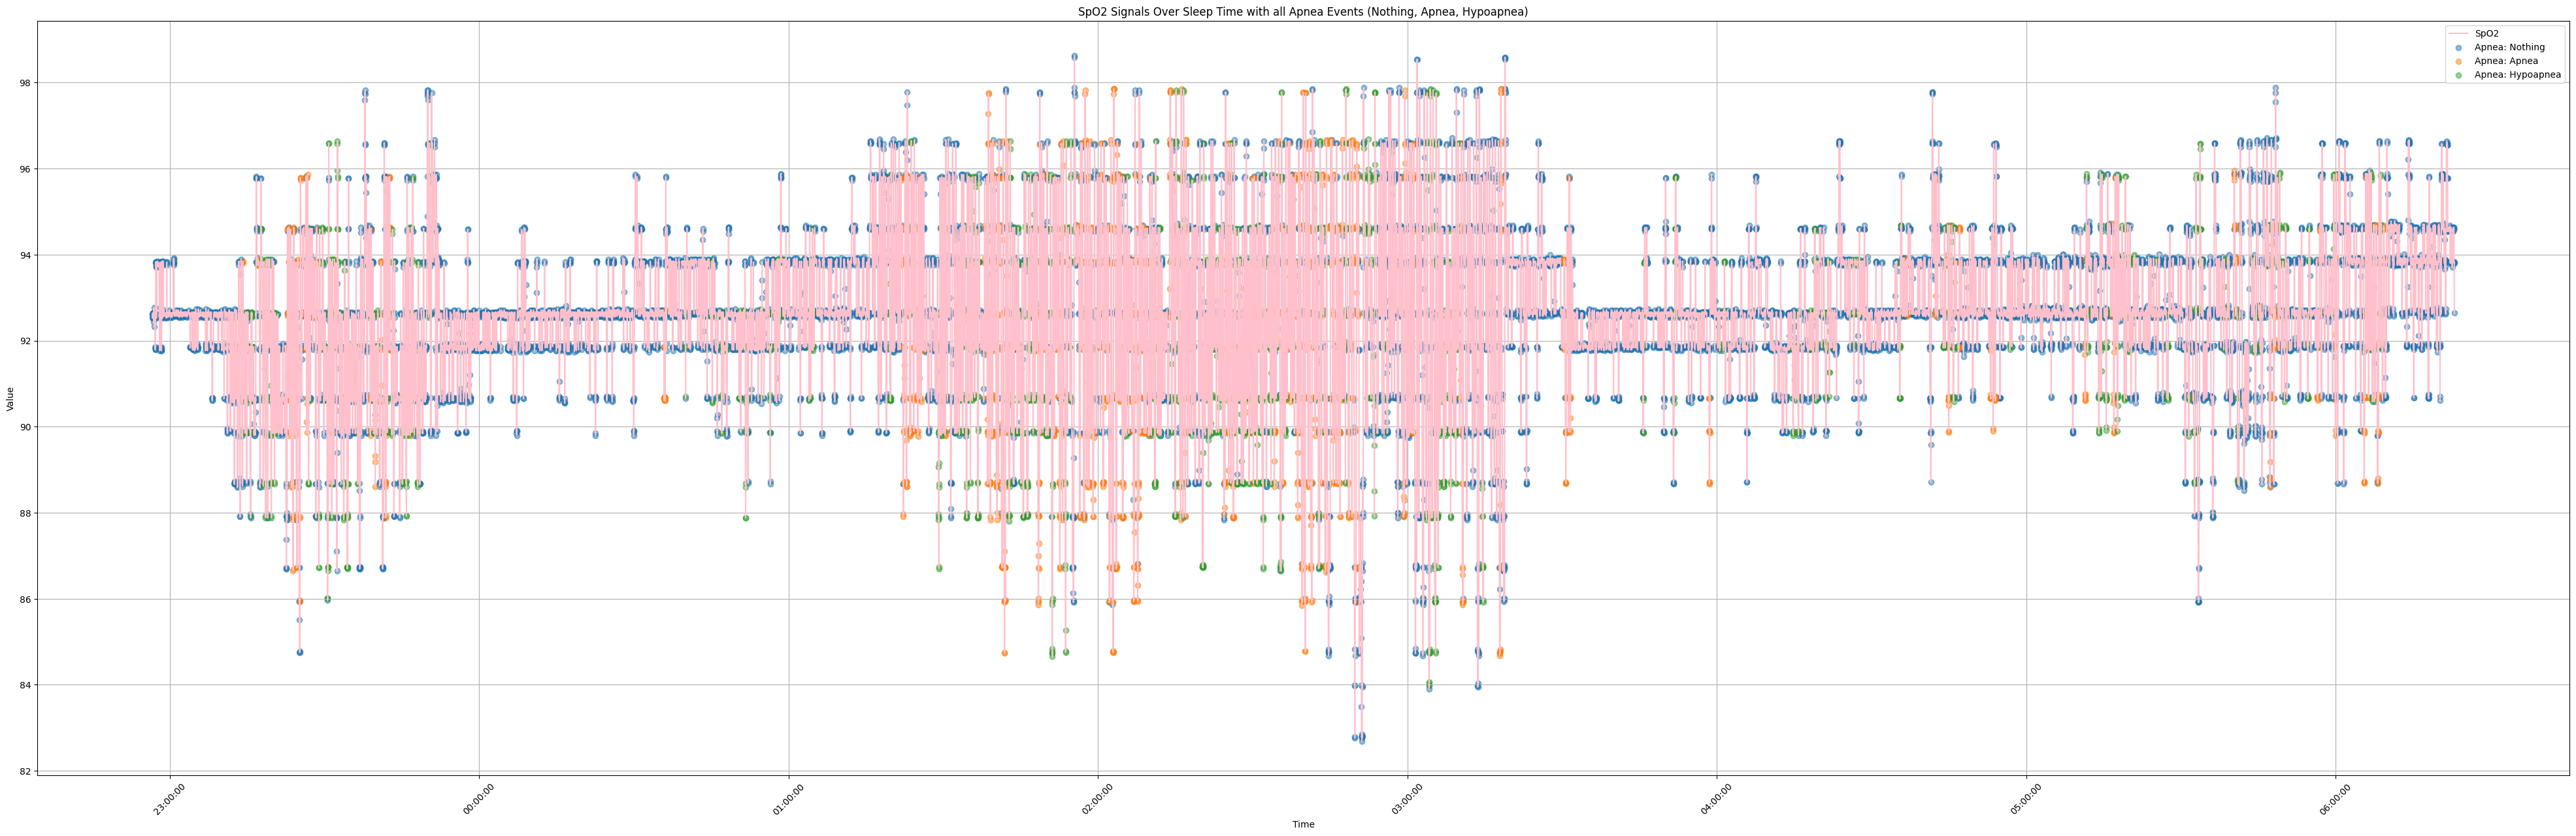

In [67]:
# @title SpO2 Signals Over Sleep Time with all Apnea Events (Nothing, Apnea, Hypoapnea) { display-mode: "both" }

# Load the data
df = pd.read_csv(final_csv)

# map "Apnea" Events
df['Apnea'] = df['Apnea'].map({'Nothing': 0, 'Apnea': 1, 'Hypoapnea': 2})

# Assuming the columns are in order: date, time, spo2, and pulse
df['Timestamp'] = df['Date'] + ' ' + df['Time']

# Parse each datetime string into a datetime object
datetime_objects = []
for dt_str in df['Timestamp']:
    try:
        # Try parsing with milliseconds
        dt_obj = datetime.strptime(dt_str, "%Y-%m-%d %H:%M:%S.%f")
    except ValueError:
        # If milliseconds are not present, parse without milliseconds
        dt_obj = datetime.strptime(dt_str, "%Y-%m-%d %H:%M:%S")
    datetime_objects.append(dt_obj)

df['Datetime'] = datetime_objects

# Plotting
plt.figure(figsize=(50, 15))

# Plot SpO2 and Pulse
plt.plot(df['Datetime'], df['SpO2'], label='SpO2', color='pink')
#plt.plot(df['Datetime'], df['Pulse'], label='Pulse', color='red')


# Highlight Apnea Events
df['Apnea'] = df['Apnea'].map({0: 'Nothing', 1: 'Apnea', 2: 'Hypoapnea'})

for apnea_event in df['Apnea'].unique():
    apnea_df = df[df['Apnea'] == apnea_event]
    plt.scatter(apnea_df['Datetime'], apnea_df['SpO2'], label=f'Apnea: {apnea_event}', alpha=0.5)


plt.title('SpO2 Signals Over Sleep Time with all Apnea Events (Nothing, Apnea, Hypoapnea)')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

# Set the format of the x-axis ticks to display only the time part
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.xticks(rotation=45)

# Save the plot to a file
plot_png = "signals_plot_with_sleep_apnea.png"
plt.savefig(plot_png)

plt.show()


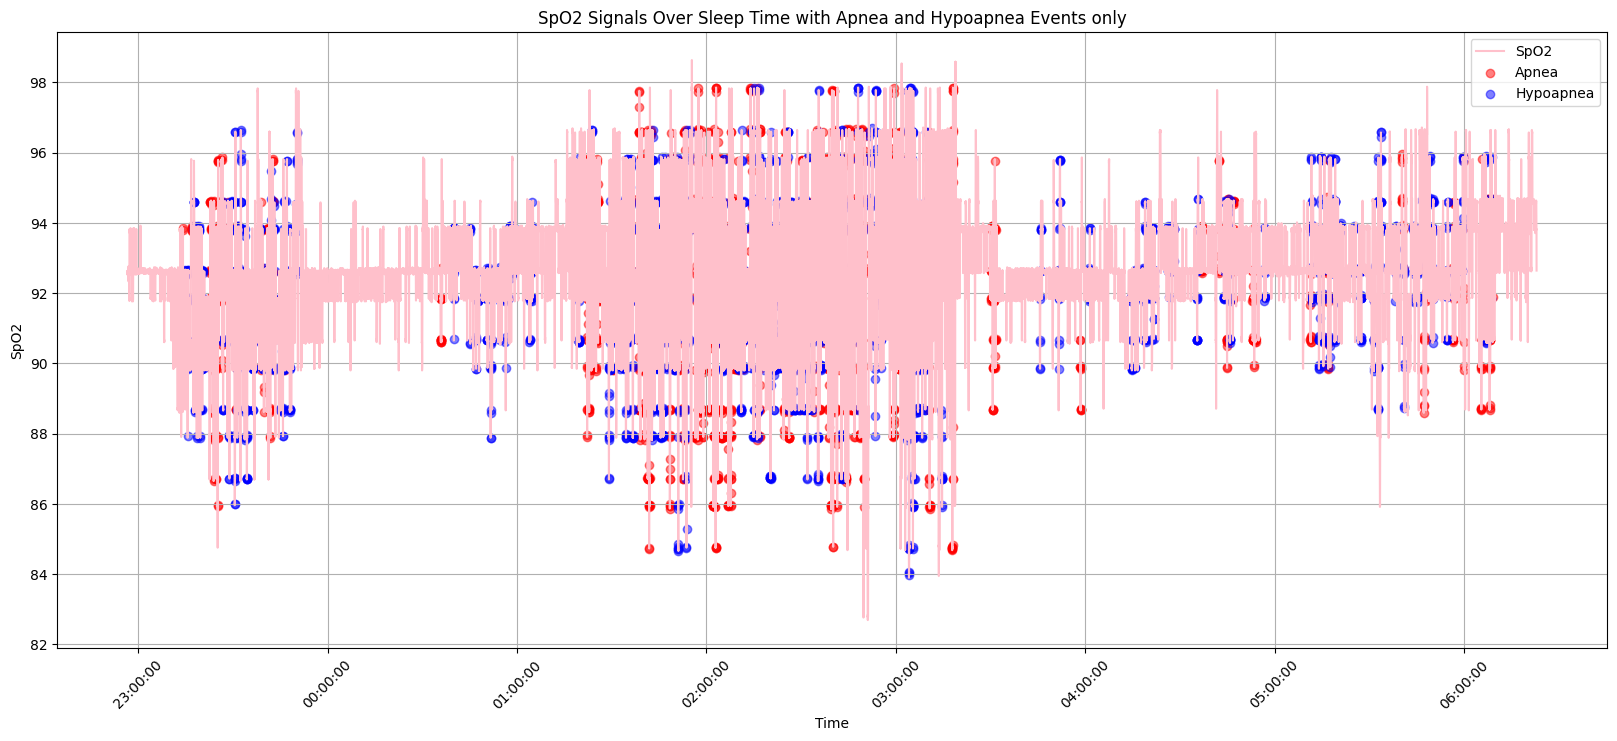

In [68]:
# @title SpO2 Signals Over Sleep Time with Apnea and Hypoapnea Events Part 2 { display-mode: "both" }

# Load the data
df = pd.read_csv(final_csv)

# map "Apnea" events
df['Apnea'] = df['Apnea'].map({'Nothing': 0, 'Apnea': 1, 'Hypoapnea': 2})

# Assuming the columns are in order: date, time, spo2, and pulse
df['Timestamp'] = df['Date'] + ' ' + df['Time']
df['Datetime'] = pd.to_datetime(df['Timestamp'])

# Plotting
plt.figure(figsize=(20, 8))

# Plot SpO2
plt.plot(df['Datetime'], df['SpO2'], label='SpO2', color='pink')

# Highlight Apnea Events
apnea_df = df[df['Apnea'] == 1]
plt.scatter(apnea_df['Datetime'], apnea_df['SpO2'], label='Apnea', color='red', alpha=0.5)

# Highlight Hypoapnea Events
hypoapnea_df = df[df['Apnea'] == 2]
plt.scatter(hypoapnea_df['Datetime'], hypoapnea_df['SpO2'], label='Hypoapnea', color='blue', alpha=0.5)

plt.title('SpO2 Signals Over Sleep Time with Apnea and Hypoapnea Events only')
plt.xlabel('Time')
plt.ylabel('SpO2')
plt.legend()
plt.grid(True)

# Set the format of the x-axis ticks to display only the time part
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.xticks(rotation=45)

plt.savefig("spo2_signals_with_apnea_hypoapnea.png")
plt.show()


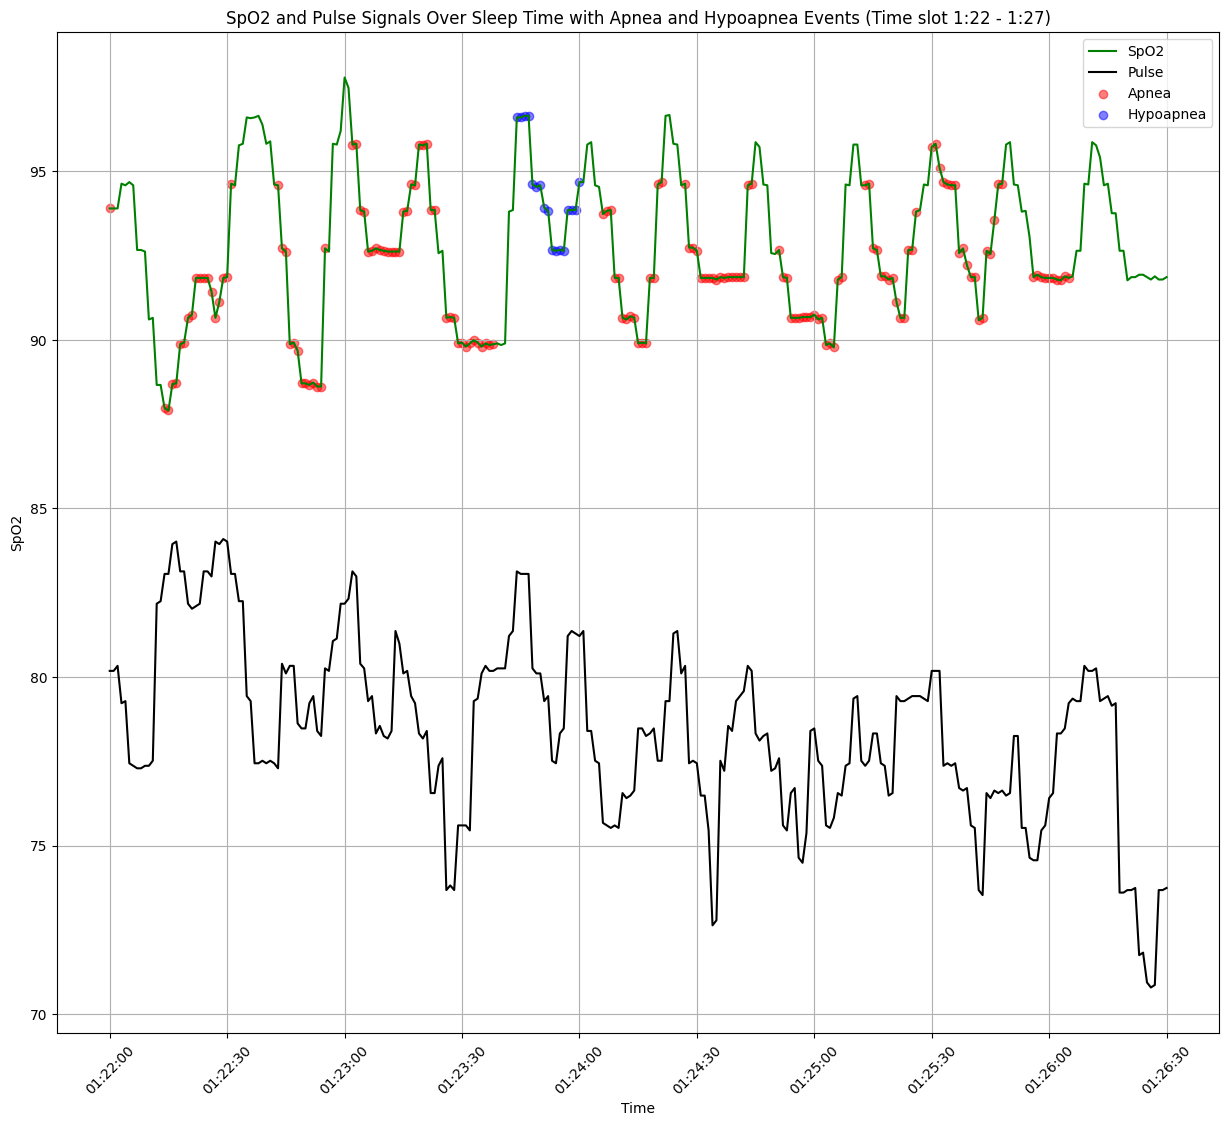

In [69]:
# @title SpO2 and Pulse Signals Over Time with Apnea and Hypoapnea Events (1:22 - 1:27) { display-mode: "both" }

# Load the data
df = pd.read_csv(final_csv)

# map "Apnea" events
df['Apnea'] = df['Apnea'].map({'Nothing': 0, 'Apnea': 1, 'Hypoapnea': 2})

# Assuming the columns are in order: date, time, spo2, and pulse
df['Timestamp'] = df['Date'] + ' ' + df['Time']
df['Datetime'] = pd.to_datetime(df['Timestamp'])

# choose the time slot
start_time = '01:22:00'
end_time = '01:26:30'
selected_df = df[(df['Datetime'].dt.time >= datetime.strptime(start_time, '%H:%M:%S').time()) &
                 (df['Datetime'].dt.time <= datetime.strptime(end_time, '%H:%M:%S').time())]

# Plotting
plt.figure(figsize=(15, 13))

# Plot SpO2
plt.plot(selected_df['Datetime'], selected_df['SpO2'], label='SpO2', color='green')
plt.plot(selected_df['Datetime'], selected_df['Pulse'], label='Pulse', color='black')

# Highlight Apnea Events
apnea_df = selected_df[selected_df['Apnea'] == 1]
plt.scatter(apnea_df['Datetime'], apnea_df['SpO2'], label='Apnea', color='red', alpha=0.5)

# Highlight Hypoapnea Events
hypoapnea_df = selected_df[selected_df['Apnea'] == 2]
plt.scatter(hypoapnea_df['Datetime'], hypoapnea_df['SpO2'], label='Hypoapnea', color='blue', alpha=0.5)

plt.title('SpO2 and Pulse Signals Over Sleep Time with Apnea and Hypoapnea Events (Time slot 1:22 - 1:27)')
plt.xlabel('Time')
plt.ylabel('SpO2')
plt.legend()
plt.grid(True)

# Set the format of the x-axis ticks to display only the time part
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.xticks(rotation=45)

plt.savefig("spo2_signals_with_apnea_hypoapnea_zoomed.png")
plt.show()


                            OLS Regression Results                            
Dep. Variable:                  Apnea   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     256.4
Date:                Tue, 11 Jun 2024   Prob (F-statistic):          1.85e-163
Time:                        21:56:03   Log-Likelihood:                -21378.
No. Observations:               21426   AIC:                         4.276e+04
Df Residuals:                   21422   BIC:                         4.280e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.0046      0.235     25.566      0.0

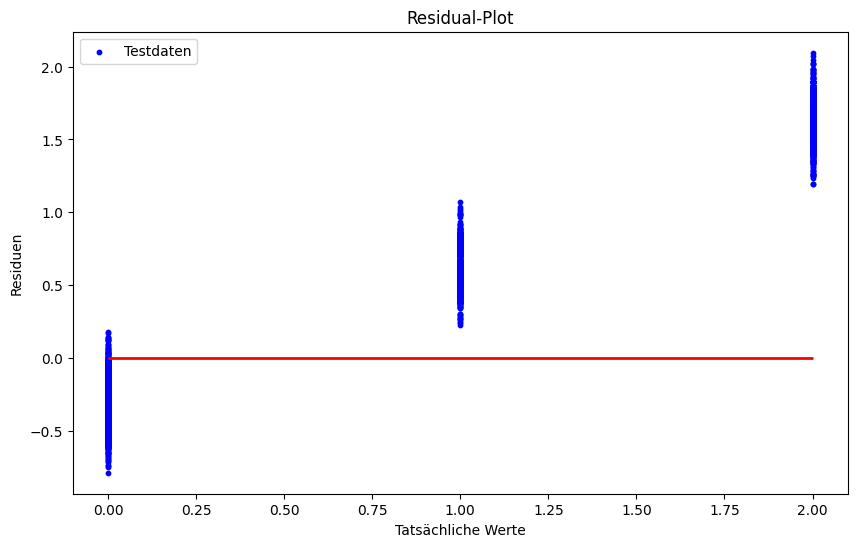

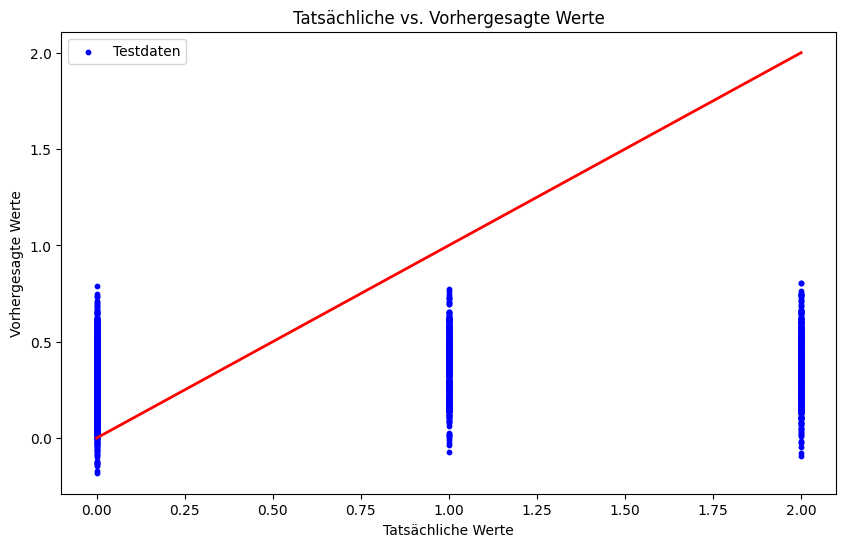

Mean Squared Error: 0.45213342257243594
R-squared: 0.039004001018247525


In [70]:
# @title multivariate regression  { display-mode: "both" }


# Daten laden
df = pd.read_csv(final_csv)
# Prepare the data
df['Apnea'] = df['Apnea'].map({'Nothing': 0, 'Apnea': 1, 'Hypoapnea': 2})
df['0'] = df['0'].map({'Wake': 0, 'REM': 1, 'Stage 1': 2, 'Stage 2': 3, 'Stage 3': 4, 'Stage 4': 5, 'Stage 5': 6, 'Interdeterminate': 7})

X = df[['SpO2', 'Pulse', '0']]
y = df['Apnea']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Add a constant to the model (intercept)
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

# Fit the regression model
model = sm.OLS(y_train, X_train_const).fit()

# Print the model summary
print(model.summary())

# Make predictions
y_pred = model.predict(X_test_const)

# Evaluate the model
plt.figure(figsize=(10, 6))

# Residual plot
plt.scatter(y_test, y_test - y_pred, color='blue', s=10, label='Testdaten')
plt.hlines(y=0, xmin=min(y_test), xmax=max(y_test), color='red', lw=2)
plt.xlabel('Tatsächliche Werte')
plt.ylabel('Residuen')
plt.title('Residual-Plot')
plt.legend()
plt.show()

# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', s=10, label='Testdaten')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2)
plt.xlabel('Tatsächliche Werte')
plt.ylabel('Vorhergesagte Werte')
plt.title('Tatsächliche vs. Vorhergesagte Werte')
plt.legend()
plt.show()

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')


**GER:**

Das Modell zeigt, dass sowohl SpO2 als auch Puls signifikante Prädiktoren für Apnoe sind, obwohl das Modell nur einen kleinen Teil der Varianz (3.3%) in Apnoe erklärt. Weitere Untersuchungen oder zusätzliche Prädiktoren könnten notwendig sein, um ein besser erklärendes Modell zu entwickeln.

**ENG:**

The model shows that both SpO2 and pulse are significant predictors of apnea, although the model explains only a small part of the variance (3.3%) in apnea. Further investigation or additional predictors may be necessary to develop a more explanatory model.